In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Bs with empkep

In [17]:
res_prefix = 'Bs_with_empkep_fix_r'

### Some functions

In [5]:
def emp_kep(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

In [10]:
# Get equidistance points

r_au_empkep_rs = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs = -r_au_empkep_rs
v_100 = 3.2 #kmps
v_rot_empkep_rs = np.sqrt(100.*np.square(v_100)/r_au_empkep_rs)
v_rot_empkep_bs = - v_rot_empkep_rs

plot_points = [r_au_empkep_rs, v_rot_empkep_rs, r_au_empkep_bs, v_rot_empkep_bs]

In [4]:
def log_likelihood(params, Y1, Y2, s1, s2, model):
    
    lg_N, T = params
    N = 10**lg_N     # We convert lg_N back to N


    # Y1 --> Tb(3-2), Y2 --> Tb(2-1)
    Y1_predicted = model.get_intensity(line = 'c18o', Ju = 3, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)
    Y2_predicted = model.get_intensity(line = 'c18o', Ju = 2, Ncol = N, Tex = T, delv = 0.5, Xconv = 1.e-7)


    #print(f" Y1 = {Y1:.1f}, Y1_pred = {Y1_predicted:.1f}")
    # Compute the log likelihood using normal distributions
    log_likelihood_Y1 = -0.5 * (np.log(2 * np.pi * s1**2) + (Y1 - Y1_predicted)**2 / s1**2)
    log_likelihood_Y2 = -0.5 * (np.log(2 * np.pi * s2**2) + (Y2 - Y2_predicted)**2 / s2**2)
    
    lg_l = log_likelihood_Y1 + log_likelihood_Y2
    return lg_l

In [6]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1], 30]) # K
    dv = 0.5

    fig, ax = model.makegrid(lines = 'c18o', J1 = 3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []

    for nc in Ncol:
        for te in Texe:
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc, Tex =te, delv = dv, Xconv=1.e-7))

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    
    for nc in Ncol:
        for te in Texe:
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc, Tex = te, delv = dv, Xconv=1.e-7))
    
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    ax.scatter(tb7, tb6, color = 'red', marker = 'o', s=50, facecolors='none', 
               edgecolors='r', label = 'Observed')
    
    plt.legend(prop={'size': 6})

    return fig, ax

In [11]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [12]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, get_surrounding_pix = False, mode='vals',
                              num_pix = 3, cf_kwargs = {'v_100':3.2})

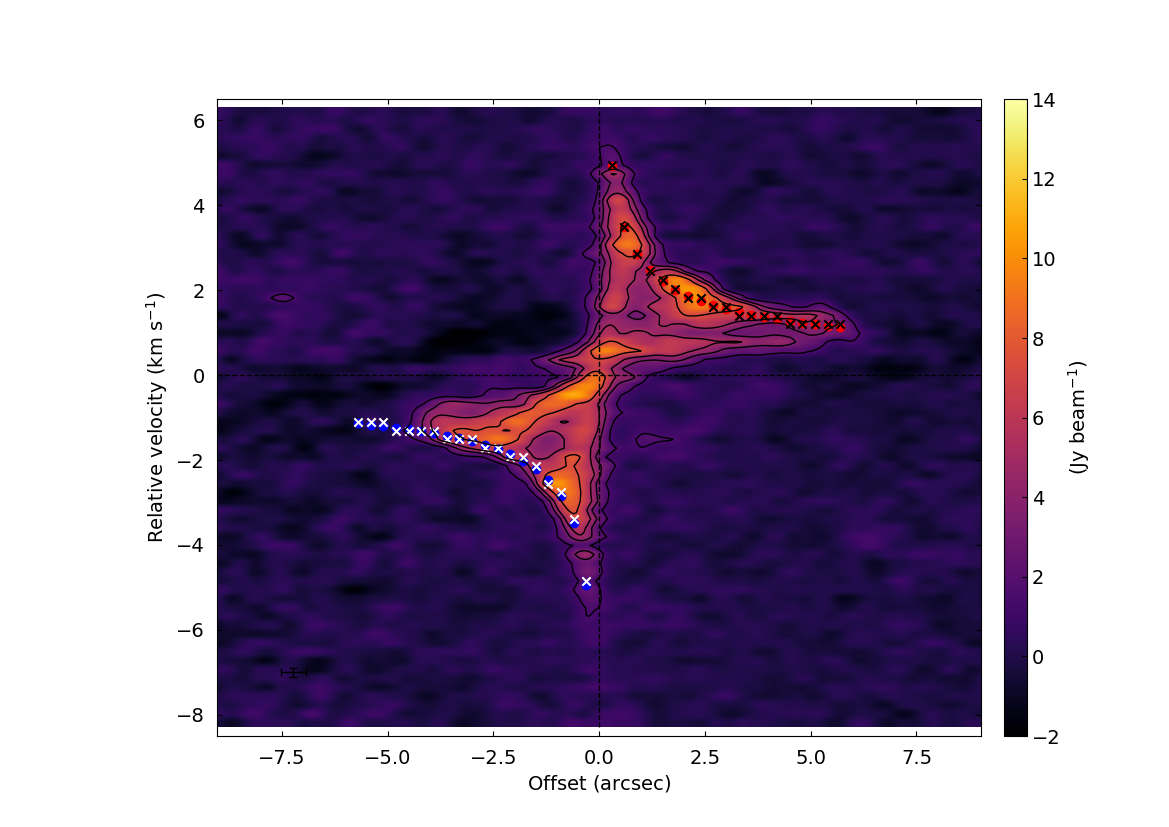

In [13]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)

In [14]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

In [30]:
Texe_bs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_bs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []


plot_corner = True


np.random.seed(42)

lg_n_bounds = [10.,20.]
T_bounds = [5.,100.]

lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

op_dir_label = "blueshifted_points_empkep_fixr"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_bs"][5:6], Tb_df_b6["Tb_on_point_bs"][5:6], 
                          pv_b6.r_as_bs[5:6], pv_b6.v_rot_blueshifted[5:6]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    # + 1.08**2   + 0.49**2

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2 ), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                    estimator='mcmc', initial_params = [18., 16.], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 10, args= None,
                                                    nwalkers = 20, n_steps = 100000, burn_in = 1000, thin_by = 20, return_flat= True,
                                                    intensity_model = lte_model, plot_chain = True, show_chains=True,
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                    "chains",op_dir_label),
                                                    )
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_bs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = 10**Ncol_qtls
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_bs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=None, 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))
                        #range=(lg_n_bounds, [1.5,65.])


        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


estimating for r = -1.800e+00 arcsec, v = -2.02 Kmps , Tb7 = 6.4, Tb6 = 5.9


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:16<00:00, 734.84it/s]


19 0


ValueError: 'x' and 'y' must have the same size

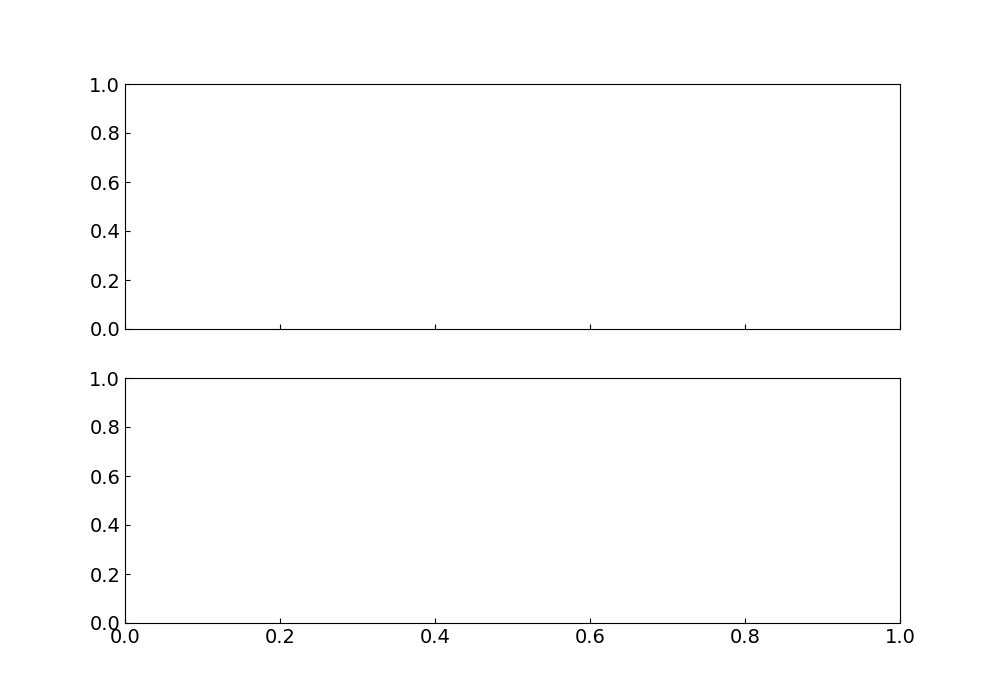

In [23]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

print(len(pv_b6.r_as_bs), len(Texe_bs_empkep[1:]))
axes[0].errorbar(-pv_b6.r_as_bs, Texe_bs_empkep[1:], yerr=Texe_bs_sgm_empkep[1:], marker='o', label = 'mcmc')
#axes[0].plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points', c='r')
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)

#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(5,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

axes[1].errorbar(-pv_b6.r_as_bs, np.array(Nexe_bs_empkep[1:])*1.0e-7, yerr=np.array(Nexe_bs_sgm_empkep[1:])*1.0e-7, marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")


#axes.set_xlim(10, 1200)
#axes.set_ylim(5,40)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})



#axes[0].set_xscale('log')
axes[1].set_xlabel("R (AU)")

In [29]:
Texe_bs_empkep = []
Texe_bs_sgm_empkep = []

Nexe_bs_empkep = []
Nexe_bs_sgm_empkep = []

list_samples = []

plot_corner = True

plot_uif = True


In [ ]:
np.random.seed(42)

lg_n_bounds = [10.,20.]
T_bounds = [5.,100.]

lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_bs"], Tb_df_b6["Tb_on_point_bs"], 
                          pv_b6.r_as_bs, pv_b6.v_rot_blueshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    # + 1.08**2   + 0.49**2

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, s1=np.sqrt((0.1*Tb7)**2), s2=np.sqrt((0.1*Tb6)**2), 
                                     estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                     bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                     initial_scatter = 10, args= None,
                                     nwalkers = 20, n_steps = 10000, burn_in = 1000, thin_by = 20, return_flat= True,
                                     intensity_model = lte_model, plot_chain = True, 
                                     r_v_info = [str(round(r,3)), str(round(v,2))], 
                                     chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains","blueshifted_points_wo_berror"),
                                     show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    Texe_bs_empkep.append(np.median(flat_samples_T))
    Texe_bs_sgm_empkep.append(np.std(flat_samples_T))
    Nexe_bs_empkep.append(np.median(10**flat_samples_N))
    Nexe_bs_sgm_empkep.append(np.std(flat_samples_N)*2.303*(np.median(10**flat_samples_N)))


    if plot_corner:


        fig = corner.corner(flat_samples, labels= ['lg_N', 'T (K)'], truths=[np.log10(Nexe_bs_empkep[-1]), Texe_bs_empkep[-1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], show_titles=True,  #range=(lg_n_bounds, [1.5,65.])
                            )

        fig.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig.subplots_adjust(top=0.86)
        figname = 'corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        figpath = os.path.join(os.path.abspath(os.getcwd()),"corner_plots","blueshifted_points_wo_berror", figname)

        fig.savefig(fname = figpath, dpi=300, format='jpeg')
        plt.close()


estimating for r = -1.093e-01 arcsec, v = -8.18 Kmps , Tb7 = 0.4, Tb6 = 0.9


100%|██████████| 10000/10000 [00:14<00:00, 669.75it/s]


estimating for r = -1.151e-01 arcsec, v = -7.97 Kmps , Tb7 = 0.3, Tb6 = 0.5


100%|██████████| 10000/10000 [00:14<00:00, 681.69it/s]


estimating for r = -1.214e-01 arcsec, v = -7.76 Kmps , Tb7 = -0.0, Tb6 = 0.0


100%|██████████| 10000/10000 [00:12<00:00, 817.42it/s]


estimating for r = -1.281e-01 arcsec, v = -7.55 Kmps , Tb7 = 1.0, Tb6 = 0.2


100%|██████████| 10000/10000 [00:13<00:00, 735.63it/s]


estimating for r = -1.355e-01 arcsec, v = -7.35 Kmps , Tb7 = 1.6, Tb6 = 1.3


100%|██████████| 10000/10000 [00:14<00:00, 683.53it/s]


estimating for r = -1.435e-01 arcsec, v = -7.14 Kmps , Tb7 = 1.3, Tb6 = 0.4


100%|██████████| 10000/10000 [00:13<00:00, 736.19it/s]


estimating for r = -1.523e-01 arcsec, v = -6.93 Kmps , Tb7 = 1.3, Tb6 = 1.0


100%|██████████| 10000/10000 [00:14<00:00, 688.70it/s]


estimating for r = -1.619e-01 arcsec, v = -6.72 Kmps , Tb7 = 0.4, Tb6 = 0.5


100%|██████████| 10000/10000 [00:14<00:00, 670.34it/s]


estimating for r = -1.724e-01 arcsec, v = -6.51 Kmps , Tb7 = 0.1, Tb6 = 0.3


100%|██████████| 10000/10000 [00:13<00:00, 756.87it/s]


estimating for r = -1.840e-01 arcsec, v = -6.30 Kmps , Tb7 = 0.7, Tb6 = 1.2


100%|██████████| 10000/10000 [00:12<00:00, 803.32it/s]


estimating for r = -1.968e-01 arcsec, v = -6.10 Kmps , Tb7 = 1.9, Tb6 = 1.2


100%|██████████| 10000/10000 [00:40<00:00, 249.05it/s]


estimating for r = -2.110e-01 arcsec, v = -5.89 Kmps , Tb7 = 1.8, Tb6 = 1.1


100%|██████████| 10000/10000 [00:13<00:00, 722.33it/s]


estimating for r = -2.267e-01 arcsec, v = -5.68 Kmps , Tb7 = 2.6, Tb6 = 1.5


100%|██████████| 10000/10000 [00:13<00:00, 724.50it/s]


estimating for r = -2.443e-01 arcsec, v = -5.47 Kmps , Tb7 = 1.9, Tb6 = 1.6


100%|██████████| 10000/10000 [00:14<00:00, 683.52it/s]


estimating for r = -2.641e-01 arcsec, v = -5.26 Kmps , Tb7 = 2.6, Tb6 = 2.1


100%|██████████| 10000/10000 [00:14<00:00, 689.73it/s]


estimating for r = -2.863e-01 arcsec, v = -5.05 Kmps , Tb7 = 3.5, Tb6 = 2.5


100%|██████████| 10000/10000 [00:14<00:00, 705.06it/s]


estimating for r = -3.114e-01 arcsec, v = -4.85 Kmps , Tb7 = 3.0, Tb6 = 1.9


100%|██████████| 10000/10000 [00:13<00:00, 722.90it/s]


estimating for r = -3.400e-01 arcsec, v = -4.64 Kmps , Tb7 = 3.6, Tb6 = 2.9


100%|██████████| 10000/10000 [00:14<00:00, 688.72it/s]


estimating for r = -3.728e-01 arcsec, v = -4.43 Kmps , Tb7 = 4.3, Tb6 = 2.5


100%|██████████| 10000/10000 [00:13<00:00, 714.50it/s]


estimating for r = -4.105e-01 arcsec, v = -4.22 Kmps , Tb7 = 4.5, Tb6 = 4.4


100%|██████████| 10000/10000 [00:14<00:00, 684.53it/s]


estimating for r = -4.542e-01 arcsec, v = -4.01 Kmps , Tb7 = 5.9, Tb6 = 1.8


100%|██████████| 10000/10000 [00:13<00:00, 744.41it/s]


estimating for r = -5.053e-01 arcsec, v = -3.80 Kmps , Tb7 = 5.5, Tb6 = 4.6


100%|██████████| 10000/10000 [00:14<00:00, 679.72it/s]


estimating for r = -5.656e-01 arcsec, v = -3.60 Kmps , Tb7 = 7.5, Tb6 = 5.6


100%|██████████| 10000/10000 [00:39<00:00, 255.89it/s]


estimating for r = -6.373e-01 arcsec, v = -3.39 Kmps , Tb7 = 9.2, Tb6 = 6.4


100%|██████████| 10000/10000 [00:38<00:00, 259.14it/s]


estimating for r = -7.235e-01 arcsec, v = -3.18 Kmps , Tb7 = 8.9, Tb6 = 7.4


100%|██████████| 10000/10000 [00:39<00:00, 252.69it/s]


estimating for r = -8.286e-01 arcsec, v = -2.97 Kmps , Tb7 = 8.8, Tb6 = 7.8


100%|██████████| 10000/10000 [00:39<00:00, 254.70it/s]


estimating for r = -9.582e-01 arcsec, v = -2.76 Kmps , Tb7 = 10.1, Tb6 = 8.6


100%|██████████| 10000/10000 [00:40<00:00, 249.63it/s]


estimating for r = -1.121e+00 arcsec, v = -2.55 Kmps , Tb7 = 10.3, Tb6 = 9.8


100%|██████████| 10000/10000 [00:29<00:00, 339.80it/s]


estimating for r = -1.329e+00 arcsec, v = -2.35 Kmps , Tb7 = 10.0, Tb6 = 6.9


100%|██████████| 10000/10000 [00:39<00:00, 256.29it/s]


estimating for r = -1.601e+00 arcsec, v = -2.14 Kmps , Tb7 = 6.5, Tb6 = 5.2


100%|██████████| 10000/10000 [00:40<00:00, 244.84it/s]


estimating for r = -1.965e+00 arcsec, v = -1.93 Kmps , Tb7 = 6.5, Tb6 = 6.1


100%|██████████| 10000/10000 [00:39<00:00, 255.70it/s]


estimating for r = -2.469e+00 arcsec, v = -1.72 Kmps , Tb7 = 10.2, Tb6 = 6.5


100%|██████████| 10000/10000 [00:14<00:00, 690.57it/s]


estimating for r = -3.197e+00 arcsec, v = -1.51 Kmps , Tb7 = 10.4, Tb6 = 7.3


100%|██████████| 10000/10000 [00:14<00:00, 674.01it/s]


estimating for r = -4.299e+00 arcsec, v = -1.30 Kmps , Tb7 = 3.3, Tb6 = 2.6


100%|██████████| 10000/10000 [00:15<00:00, 663.81it/s]


estimating for r = -6.089e+00 arcsec, v = -1.10 Kmps , Tb7 = -0.6, Tb6 = -0.6


100%|██████████| 10000/10000 [00:12<00:00, 802.15it/s]


In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

print(len(pv_b6.r_as_bs), len(Texe_bs_empkep[1:]))
axes[0].errorbar(-pv_b6.r_as_bs, Texe_bs_empkep[1:], yerr=Texe_bs_sgm_empkep[1:], marker='o', label = 'mcmc')
#axes[0].plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points', c='r')
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)

#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(5,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

axes[1].errorbar(-pv_b6.r_as_bs, np.array(Nexe_bs_empkep[1:])*1.0e-7, yerr=np.array(Nexe_bs_sgm_empkep[1:])*1.0e-7, marker='o', label = 'mcmc')
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")


#axes.set_xlim(10, 1200)
#axes.set_ylim(5,40)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})



#axes[0].set_xscale('log')
axes[1].set_xlabel("R (AU)")